# Deep Dream

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import PIL.Image
import tensorflow as tf
from io import BytesIO

In [2]:
graph = tf.Graph()
session = tf.InteractiveSession(graph=graph)

In [3]:
model_nn = "inception5h/tensorflow_inception_graph.pb"
with tf.gfile.FastGFile(model_nn, 'rb') as f:
    graph_def = tf.GraphDef()
    graph_def.ParseFromString(f.read())

In [4]:
t_input = tf.placeholder(np.float32, name='input') #imagenes de entrada
imagenet_mean = 117.0 #media de los valores de las imagenes
t_preprocessed = tf.expand_dims(t_input-imagenet_mean,0) #estandarizacion de imagenes 
tf.import_graph_def(graph_def, {'input':t_preprocessed}) #carga de los datos en el grafo

In [5]:
layers = [op.name for op in graph.get_operations() if op.type=="Conv2D" and "import/" in op.name]

In [6]:
layers #capas de convoluciones 2D

['import/conv2d0_pre_relu/conv',
 'import/conv2d1_pre_relu/conv',
 'import/conv2d2_pre_relu/conv',
 'import/mixed3a_1x1_pre_relu/conv',
 'import/mixed3a_3x3_bottleneck_pre_relu/conv',
 'import/mixed3a_3x3_pre_relu/conv',
 'import/mixed3a_5x5_bottleneck_pre_relu/conv',
 'import/mixed3a_5x5_pre_relu/conv',
 'import/mixed3a_pool_reduce_pre_relu/conv',
 'import/mixed3b_1x1_pre_relu/conv',
 'import/mixed3b_3x3_bottleneck_pre_relu/conv',
 'import/mixed3b_3x3_pre_relu/conv',
 'import/mixed3b_5x5_bottleneck_pre_relu/conv',
 'import/mixed3b_5x5_pre_relu/conv',
 'import/mixed3b_pool_reduce_pre_relu/conv',
 'import/mixed4a_1x1_pre_relu/conv',
 'import/mixed4a_3x3_bottleneck_pre_relu/conv',
 'import/mixed4a_3x3_pre_relu/conv',
 'import/mixed4a_5x5_bottleneck_pre_relu/conv',
 'import/mixed4a_5x5_pre_relu/conv',
 'import/mixed4a_pool_reduce_pre_relu/conv',
 'import/mixed4b_1x1_pre_relu/conv',
 'import/mixed4b_3x3_bottleneck_pre_relu/conv',
 'import/mixed4b_3x3_pre_relu/conv',
 'import/mixed4b_5x5_bo

In [7]:
feature_num = [int(graph.get_tensor_by_name(name+':0').get_shape()[-1]) for name in layers] #neuronas de cada capa

In [8]:
feature_num

[64,
 64,
 192,
 64,
 96,
 128,
 16,
 32,
 32,
 128,
 128,
 192,
 32,
 96,
 64,
 192,
 96,
 204,
 16,
 48,
 64,
 160,
 112,
 224,
 24,
 64,
 64,
 128,
 128,
 256,
 24,
 64,
 64,
 112,
 144,
 288,
 32,
 64,
 64,
 256,
 160,
 320,
 32,
 128,
 128,
 256,
 160,
 320,
 48,
 128,
 128,
 384,
 192,
 384,
 48,
 128,
 128,
 128,
 128]

In [9]:
layer = "mixed4d_3x3_bottleneck_pre_relu"
channel = 139 #rasgo o neurona numero 139 de la capa
im_noise = np.random.uniform(size = (224,224,3))+100.0 #imagen de entrenamiento

In [30]:
#Funcion que pintara imagen desde array
def show_array(a, fmt = "jpeg"):
    a = np.uint8(np.clip(a,0,1)*255) #valores (negativos=0, valores positivos=1)*255 es decir valores entre 0 y 255
    f = BytesIO() #fichero
    PIL.Image.fromarray(a).save(f, fmt) #se crea imagen desde array "a"  save(fichero, formato)
    plt.imshow(a)
    plt.show()

In [11]:
#Funcion helper para completar el nombre de la capa
def T(layer):
    return graph.get_tensor_by_name("import/%s:0"%layer)

In [12]:
#Funcion que crea placeholders
def tf_func(*argtypes):
    placeholders = list(map(tf.placeholder, argtypes))
    def wrap(f):
        out = f(*placeholders)
        def wrapper(*args, **kw):
            return out.eval(dict(zip(placeholders, args)), session=kw.get('session'))
        return wrapper
    return wrap

In [13]:
def resize(img, size):
    img = tf.expand_dims(img,0) #esto es para poder realizar la interpolacion lineal
    return tf.image.resize_bilinear(img, size)[0,:,:,:]

In [14]:
#Funcion que calcula el gradiente en ciertas partes de la imagen
def calc_grad_tiled(img, t_grad, tile_size=512):
    sz = tile_size
    h,w = img.shape[:2] #ancho y alto
    sx, sy = np.random.randint(sz,size = 2)
    img_shift = np.roll(np.roll(img,sx,1),sy,0)
    grad = np.zeros_like(img)
    for y in range(0, max(h-sz//2, sz), sz):
        for x in range(0, max(w-sz//2, sz), sz):
            sub = img_shift[y:y+sz, x:x+sz]
            g = session.run(t_grad, {t_input:sub})
            grad[y:y+sz, x:x+sz] = g
    return np.roll(np.roll(grad, -sx, 1), -sy,0)

In [25]:
#Funcion para extraer la media del rasgo que queremos
def render_deepdream(t_obj, img0=im_noise, iter_n = 10, step = 1.5, octave_n = 4, octave_scale = 1.4):
    t_score = tf.reduce_mean(t_obj)
    t_grad = tf.gradients(t_score, t_input)[0]
    img = img0
    octaves = [] #bajas frecuencias
    for i in range(octave_n-1):
        hw = img.shape[:2]
        lo = resize(img, np.int32(np.float32(hw)/octave_scale))
        hi = img-resize(lo, hw)
        img = lo
        octaves.append(hi)
    
    for octave in range(octave_n):
        if octave > 0:
            hi = octaves[-octave]#empezamos desde el último octave la reconstrucción
            img = resize(img, hi.shape[:2]) + hi
        for i in range(iter_n):
            g = calc_grad_tiled(img, t_grad)
            img += g*(step / (np.abs(g).mean()+1e-7))
            print(".", end=" ")
        show_array(img/255.0)

In [16]:
resize = tf_func(np.float32, np.int32)(resize)

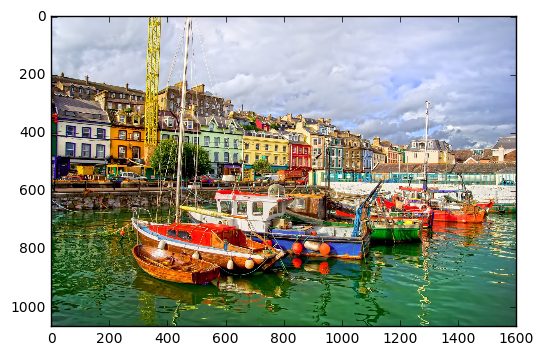

In [31]:
img0=PIL.Image.open('datasets/stylenet/original_image.jpg')
img0=np.float32(img0)
show_array(img0/255.0)

. . . . . . . . . . . . . . . 

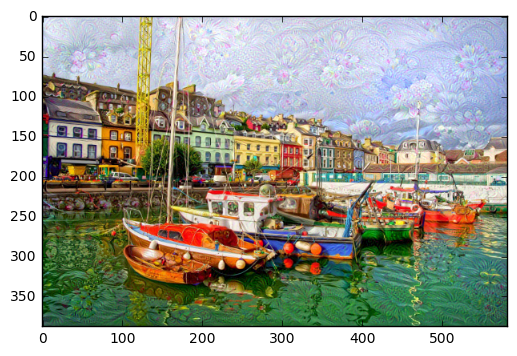

. . . . . . . . . . . . . . . 

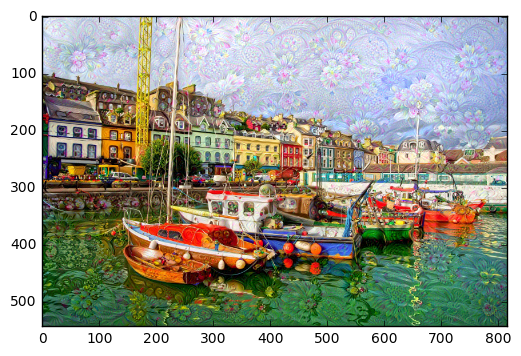

. . . . . . . . . . . . . . . 

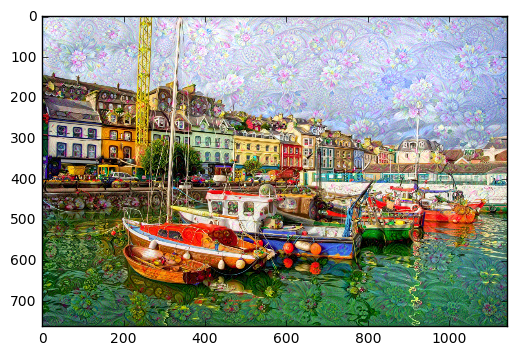

. . . . . . . . . . . . . . . 

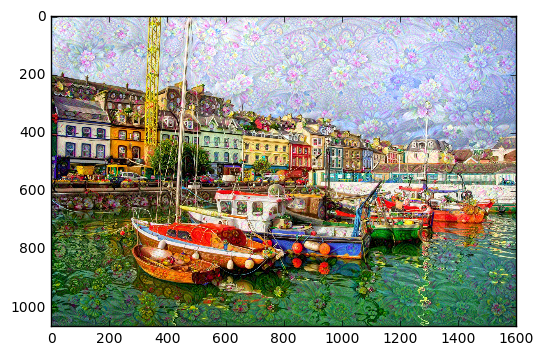

In [32]:
render_deepdream(T(layer)[:,:,:,139],img0=img0,iter_n=15)